In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# Matplotlib 한글 폰트 설정 (Windows - Malgun Gothic)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print("--- '이탈 위험 고객' 상세 분석 시작 ---")

--- '이탈 위험 고객' 상세 분석 시작 ---


In [2]:
# 1. 데이터 읽기
# '배송 일자'도 날짜 계산을 위해 parse_dates에 포함
df = pd.read_csv('store_data.csv', parse_dates=['주문 일자', '배송 일자'])

# 2. 배송 소요 시간(Days to Ship) 계산
# 배송 일자 - 주문 일자 (일 단위)
df['배송 소요 시간'] = (df['배송 일자'] - df['주문 일자']).dt.days

# 3. RFM 계산 및 세그먼트 분류 (이전 로직 동일)
snapshot_date = df['주문 일자'].max() + pd.Timedelta(days=1)
rfm_df = df.groupby('고객번호').agg(
    Recency=('주문 일자', lambda x: (snapshot_date - x.max()).days),
    Frequency=('주문 번호', 'nunique'),
    Monetary=('매출', 'sum')
).reset_index()

# 분류 기준 적용
R_CUTOFF = 173
F_CUTOFF = 9
M_CUTOFF = 6547279

def segment_customer(row):
    if row['Recency'] >= R_CUTOFF: return '이탈 위험'
    elif (row['Frequency'] >= F_CUTOFF) and (row['Monetary'] >= M_CUTOFF): return '우수'
    else: return '일반'

rfm_df['Segment'] = rfm_df.apply(segment_customer, axis=1)

# 원본 데이터에 세그먼트 병합
df_merged = df.merge(rfm_df[['고객번호', 'Segment']], on='고객번호', how='left')

# 분석 그룹 정의
churn_df = df_merged[df_merged['Segment'] == '이탈 위험']
active_df = df_merged[df_merged['Segment'].isin(['우수', '일반'])]

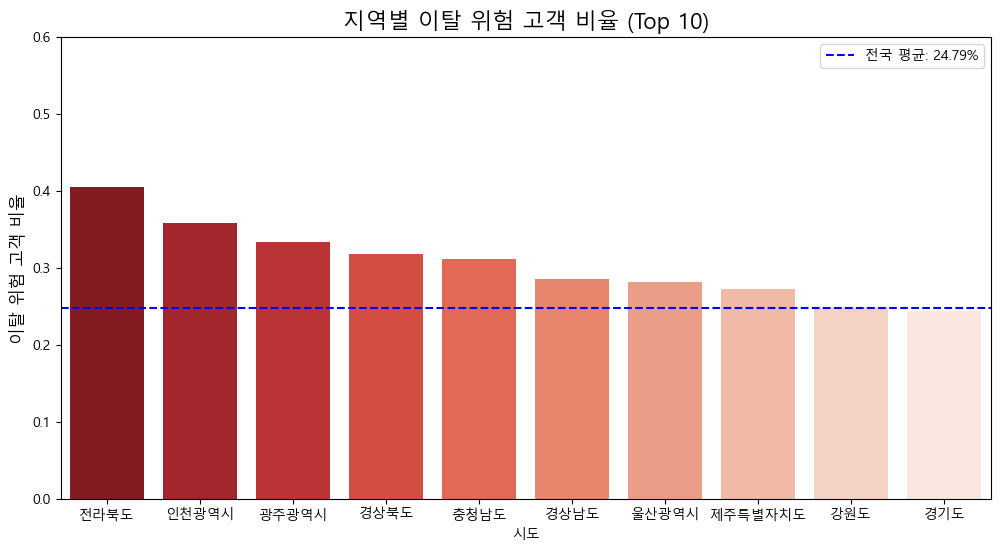

In [3]:
# --- 분석 1: 지역별 이탈 위험도 (Churn Rate) ---
# 시도별 전체 고객 수
city_total = df_merged.groupby('시도')['고객번호'].nunique()
# 시도별 이탈 위험 고객 수
city_churn = churn_df.groupby('시도')['고객번호'].nunique()
# 이탈률 계산 (이탈 수 / 전체 수)
city_churn_rate = (city_churn / city_total).fillna(0).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
# 상위 10개 지역만 시각화
sns.barplot(x=city_churn_rate.head(10).index, y=city_churn_rate.head(10).values, palette='Reds_r')
plt.title('지역별 이탈 위험 고객 비율 (Top 10)', fontsize=16)
plt.ylabel('이탈 위험 고객 비율', fontsize=12)
plt.axhline(city_churn_rate.mean(), color='blue', linestyle='--', label=f'전국 평균: {city_churn_rate.mean():.2%}')
plt.legend()
plt.ylim(0, 0.6) # y축 범위 조정
plt.show()

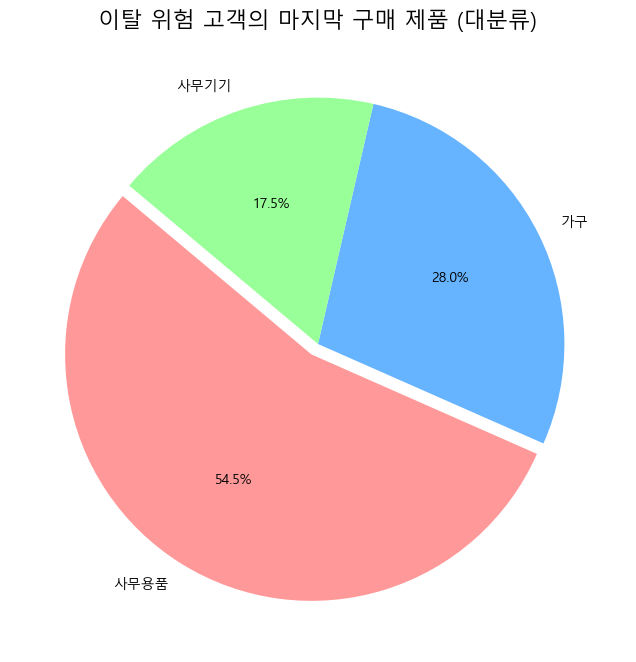

In [4]:
# --- 분석 2: 이탈 위험 고객의 마지막 구매 카테고리 ---
# 고객별 마지막 주문 추출
last_orders = churn_df.sort_values('주문 일자').groupby('고객번호').tail(1)
last_category_counts = last_orders['제품 대분류'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(last_category_counts, labels=last_category_counts.index, autopct='%1.1f%%', 
        startangle=140, colors=['#ff9999','#66b3ff','#99ff99'], explode=(0.05, 0, 0))
plt.title('이탈 위험 고객의 마지막 구매 제품 (대분류)', fontsize=16)
plt.show()

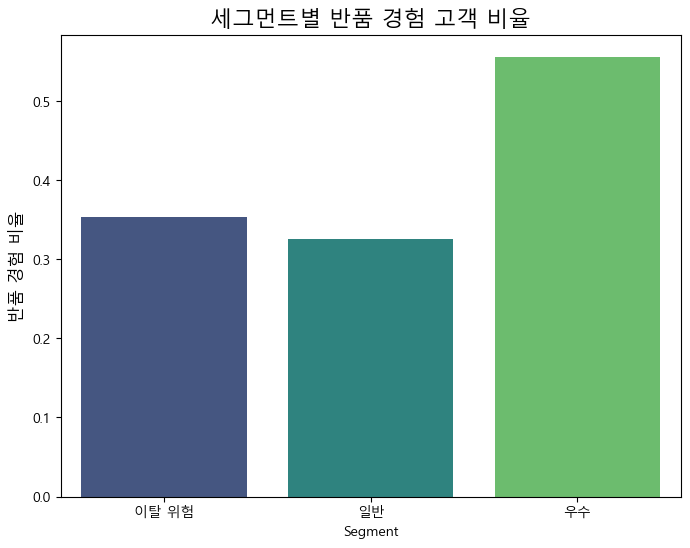

In [5]:
# --- 분석 3: 반품 경험 여부 비교 ---
# 고객별 반품 경험 유무 (True/False)
df_merged['Has_Returned'] = df_merged.groupby('고객번호')['반품'].transform(lambda x: (x == 'Yes').any())
# 세그먼트별 반품 경험 비율 계산
return_rate_by_segment = df_merged.groupby('Segment')['Has_Returned'].mean()

plt.figure(figsize=(8, 6))
sns.barplot(x=return_rate_by_segment.index, y=return_rate_by_segment.values, 
            order=['이탈 위험', '일반', '우수'], palette='viridis')
plt.title('세그먼트별 반품 경험 고객 비율', fontsize=16)
plt.ylabel('반품 경험 비율', fontsize=12)
plt.show()

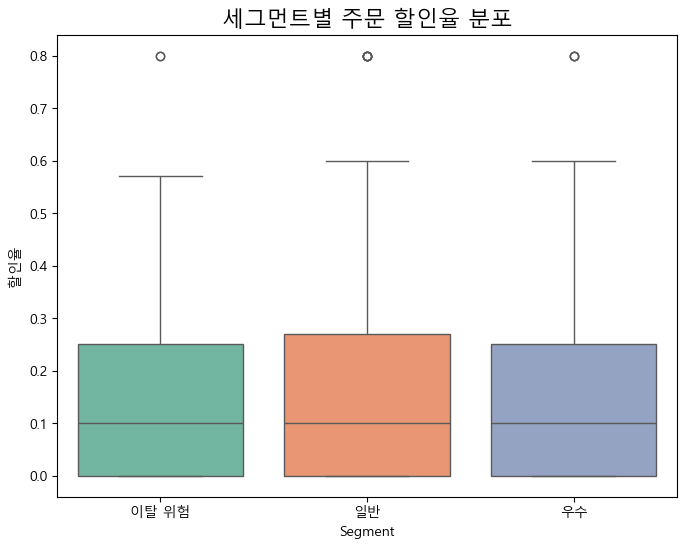

이탈 위험 고객 상세 분석 완료


In [6]:
# --- 분석 4: 평균 할인율 비교 ---
plt.figure(figsize=(8, 6))
sns.boxplot(x='Segment', y='할인율', data=df_merged, order=['이탈 위험', '일반', '우수'], palette='Set2')
plt.title('세그먼트별 주문 할인율 분포', fontsize=16)
plt.show()

print("이탈 위험 고객 상세 분석 완료")


--- 1. 세그먼트별 배송 소요 시간 비교 ---
          count      mean       std  min  25%  50%  75%  max
Segment                                                     
우수       1997.0  3.998998  1.682754  0.0  3.0  4.0  5.0  7.0
이탈 위험    2168.0  4.086255  1.690232  0.0  3.0  4.0  5.0  7.0
일반       6832.0  3.924473  1.688310  0.0  3.0  4.0  5.0  8.0


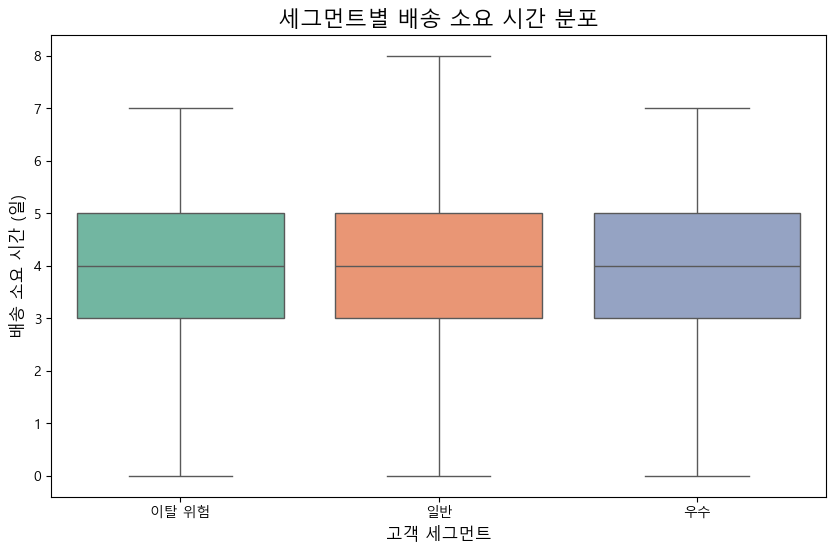

In [7]:
# --- 분석 5: 배송 소요 시간 비교 ---
print("\n--- 1. 세그먼트별 배송 소요 시간 비교 ---")

# 통계량 계산
shipping_time_stats = df_merged.groupby('Segment')['배송 소요 시간'].describe()
print(shipping_time_stats)

# 시각화: 박스플롯 (Boxplot)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Segment', y='배송 소요 시간', data=df_merged, 
            order=['이탈 위험', '일반', '우수'], palette='Set2')
plt.title('세그먼트별 배송 소요 시간 분포', fontsize=16)
plt.xlabel('고객 세그먼트', fontsize=12)
plt.ylabel('배송 소요 시간 (일)', fontsize=12)
plt.show()


--- 2. 세그먼트별 배송 방법 선호도 비교 ---
배송 방법    당일 배송  빠른 배송  특급 배송  표준 배송
Segment                            
이탈 위험     4.66  20.53  13.19  61.62
일반        4.96  20.40  14.52  60.11
우수        4.71  18.68  15.32  61.29


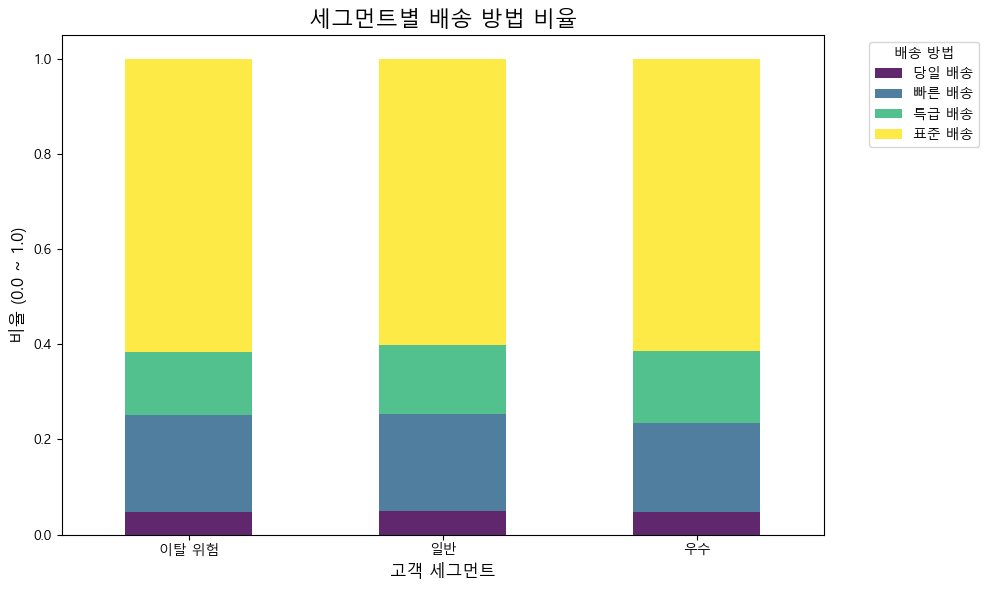


배송 관련 상세 분석 완료


In [8]:
# --- 분석 6: 배송 방법 차이 비교 ---
print("\n--- 2. 세그먼트별 배송 방법 선호도 비교 ---")

# 교차표(Crosstab) 생성: 세그먼트별 각 배송 방법의 비율 계산
# normalize='index'를 사용하여 행(세그먼트)별 합이 1(100%)이 되도록 함
shipping_mode_counts = pd.crosstab(df_merged['Segment'], df_merged['배송 방법'], normalize='index')
# 보기 좋게 %로 변환 및 정렬
shipping_mode_counts = shipping_mode_counts.loc[['이탈 위험', '일반', '우수']] 
print((shipping_mode_counts * 100).round(2))

# 시각화: 누적 막대 차트 (Stacked Bar Chart)
shipping_mode_counts.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis', alpha=0.85)
plt.title('세그먼트별 배송 방법 비율', fontsize=16)
plt.xlabel('고객 세그먼트', fontsize=12)
plt.ylabel('비율 (0.0 ~ 1.0)', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='배송 방법', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("\n배송 관련 상세 분석 완료")

1. 세그먼트별 객단가(AOV) 분석 중...


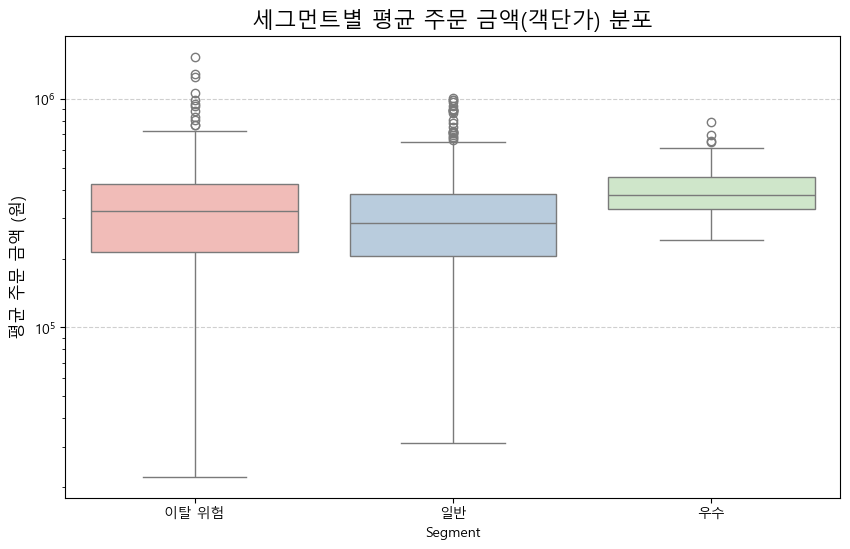

In [9]:
# --- 분석 7: 세그먼트별 객단가(AOV) 비교 (Boxplot) ---
print("1. 세그먼트별 객단가(AOV) 분석 중...")

# 고객별 평균 주문 금액(AOV) 계산
customer_avg = df_merged.groupby(['고객번호', 'Segment'])['매출'].mean().reset_index()
customer_avg.rename(columns={'매출': 'Avg_Order_Value'}, inplace=True)

# 시각화: 객단가 박스플롯
plt.figure(figsize=(10, 6))
sns.boxplot(x='Segment', y='Avg_Order_Value', data=customer_avg, 
            order=['이탈 위험', '일반', '우수'], palette='Pastel1')
plt.title('세그먼트별 평균 주문 금액(객단가) 분포', fontsize=16)
plt.ylabel('평균 주문 금액 (원)', fontsize=12)
plt.yscale('log') # 금액 차이가 크므로 로그 스케일 적용
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

2. 세그먼트별 구매 카테고리 다양성 분석 중...


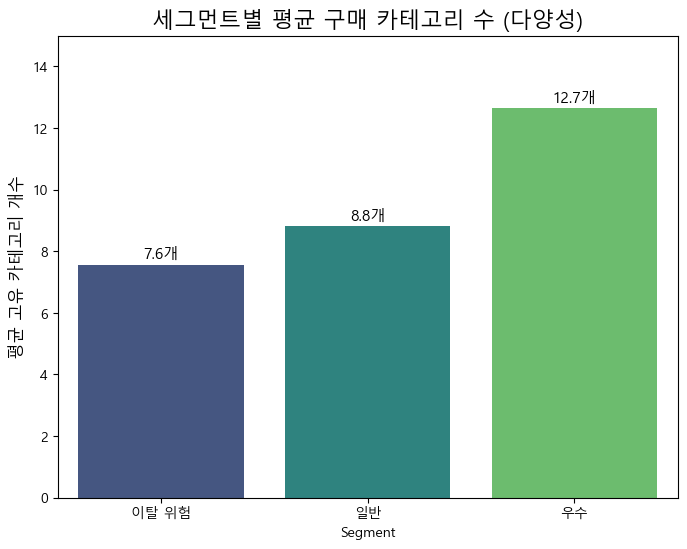

In [10]:
# --- 분석 8: 구매 카테고리 다양성 비교 (Bar Chart) ---
print("2. 세그먼트별 구매 카테고리 다양성 분석 중...")

# 고객별 구매한 고유 '제품 중분류' 개수 계산
customer_variety = df_merged.groupby(['고객번호', 'Segment'])['제품 중분류'].nunique().reset_index()
customer_variety.rename(columns={'제품 중분류': 'Unique_Categories'}, inplace=True)

# 세그먼트별 평균 다양성 계산
segment_variety = customer_variety.groupby('Segment')['Unique_Categories'].mean()

# 시각화: 카테고리 다양성 막대 차트
plt.figure(figsize=(8, 6))
sns.barplot(x=segment_variety.index, y=segment_variety.values, 
            order=['이탈 위험', '일반', '우수'], palette='viridis')
plt.title('세그먼트별 평균 구매 카테고리 수 (다양성)', fontsize=16)
plt.ylabel('평균 고유 카테고리 개수', fontsize=12)
# 막대 위에 수치 표시
for index, value in enumerate(segment_variety.reindex(['이탈 위험', '일반', '우수'])):
    plt.text(index, value + 0.2, f'{value:.1f}개', ha='center', fontsize=11)
plt.ylim(0, 15)
plt.show()